In [181]:
!pip install transformers chromadb langchain pypdf2 tiktoken unstructured[pdf] langchain_community sentence-transformers pypdf openai Pillow pytesseract ragas

In [182]:
!pip install langchain

In [3]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [4]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [5]:
!pip install llama-cpp-python==0.1.78

In [6]:
# Check poppler installation (optional)
!pdfinfo -v

pdfinfo version 22.02.0
Copyright 2005-2022 The Poppler Developers - http://poppler.freedesktop.org
Copyright 1996-2011 Glyph & Cog, LLC


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from transformers import  AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("BioMistral/BioMistral-7B")
model = AutoModelForCausalLM.from_pretrained("BioMistral/BioMistral-7B")

In [10]:
import sys; sys.path.append(".")
import warnings; warnings.filterwarnings("ignore")

In [11]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import Chroma
import chromadb

In [12]:
from langchain.chains.question_answering import load_qa_chain
from langchain_community.document_loaders import UnstructuredFileLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [13]:
!pip install sentence-transformers

In [19]:
from langchain_community.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.schema.runnable import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.chains import RetrievalQA
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

In [16]:
import transformers
import os
import shutil

In [21]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer

embeddings = HuggingFaceBgeEmbeddings(model_name="neuml/pubmedbert-base-embeddings-matryoshka",
                                           model_kwargs={"device": "cuda"},
                                           encode_kwargs={"device": "cuda", "normalize_embeddings": True})

In [22]:
DATA_DIR =  "/content/drive/My Drive/data/"
chunk_size=700
chunk_overlap=50

In [23]:
for file in os.listdir(DATA_DIR):
  if file.endswith('.pdf'):
    print(file)

mRNA Vaccine.pdf
Parkinsons.pdf


In [29]:
from langchain_community.document_loaders import UnstructuredFileLoader
import warnings
warnings.filterwarnings("ignore")

DATA_DIR = "/content/drive/My Drive/data/"

documents = []
for file in os.listdir(DATA_DIR):
  if file.endswith('.pdf'):
    print(os.path.join(DATA_DIR, file))
    pdf_path = os.path.join(DATA_DIR, file)
    loader = UnstructuredFileLoader(pdf_path)
    data = loader.load()
    documents.extend(data)


/content/drive/My Drive/data/mRNA Vaccine.pdf


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/content/drive/My Drive/data/Parkinsons.pdf


In [32]:
# documents[0]

In [33]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size,
                                                 chunk_overlap=chunk_overlap,
                                                 separators=["\n\n", "\n", " ", ""])
chunked_documents = text_splitter.split_documents(documents)

In [34]:
chunked_documents[0]

Document(page_content='viruses\n\n\n\nReview mRNA Vaccine Nanoplatforms and Innate Immunity\n\nLai Wei, Chunhong Dong , Wandi Zhu and Bao-Zhong Wang *\n\nCenter for Inﬂammation, Immunity & Infection, Institute for Biomedical Sciences, Georgia State University, Atlanta, GA 30303, USA; lwei11@student.gsu.edu (L.W.); cdong@gsu.edu (C.D.); wzhu3@gsu.edu (W.Z.) * Correspondence: bwang23@gsu.edu', metadata={'source': '/content/drive/My Drive/data/mRNA Vaccine.pdf'})

In [35]:
client = chromadb.Client()

In [36]:
collection = client.create_collection("vector_db")

In [37]:
MODEL_NAME = ""

In [39]:
MODEL_NAME = 'BioMistral/BioMistral-7B'
CHUNK_SIZE = chunk_size
CHUNK_OVERLAP = chunk_overlap
persist_directory = f"content/drive/My Drive/data/vector_db/{MODEL_NAME}_{CHUNK_SIZE}_{CHUNK_OVERLAP}"

In [40]:
persist_directory

'content/drive/My Drive/data/vector_db/BioMistral/BioMistral-7B_700_50'

In [41]:
vectordb = Chroma.from_documents(
    documents=chunked_documents,
    embedding=embeddings,
    persist_directory=persist_directory
)

In [42]:
# save the database so we can use it later
vectordb.persist()

In [43]:
# check that the database have been created and get the number of documents
print(vectordb._collection.count())

600


In [44]:
retriever = vectordb.as_retriever(search_kwargs={"k":2})

In [45]:
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceBgeEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7d555b601ea0>, search_kwargs={'k': 2})

In [46]:
question = "Symptoms of Parkinson's disease"
embedded_question = embeddings.embed_query(question)
docs = vectordb.similarity_search_by_vector_with_relevance_scores(embedded_question,k=2)

docs

[(Document(page_content='Abstract In severe cases, Parkinson’s disease causes uncontrolled movements known as motor symptoms such as dystonia, rigidity, bradykinesia, and tremors. Parkinson’s disease also causes non-motor symptoms such as insomnia, constipation, depression and hysteria. Disruption of dopaminergic and non-dopaminergic neural networks in the substantia nigra pars compacta is a major cause of motor symptoms in Parkinson’s disease. Furthermore, due to the difficulty of clinical diagnosis of Parkinson’s disease, it is often misdiagnosed, highlighting the need for better methods of detection. Treatment of Parkinson’s disease is also complicated due to the difficulties of medications passing across the', metadata={'source': '/content/drive/My Drive/data/Parkinsons.pdf'}),
  0.8246270418167114),
 (Document(page_content="neurons in the substantia nigra pars compacta as well as the formation of intraneuronal Lewy bodies in the brain (Wal et al. 2022). Parkinson's disease is clin

In [47]:
question = "What are polymer based mRNA?"
embedded_question = embeddings.embed_query(question)
docs = vectordb.similarity_search_by_vector_with_relevance_scores(embedded_question,k=2)

docs

[(Document(page_content='Owing to the excellent ﬂexibility in molecular structure design and modiﬁcations, polymer-based delivery platforms are also promising mRNA delivery platforms and hold massive potential for future mRNA applications. The activation of innate immunity by polymers reveals potential adjuvant effects, in addition to the ability for mRNA shielding and delivery. However, up to date, no commercial polymer-based mRNA vaccines have been developed. The ongoing quest for more potent polymers persists. Moreover, the limited data hinders a comprehensive understanding of the innate immune responses and side effects associated with mRNA polymer vaccines. In-depth studies are needed to address gaps in our', metadata={'source': '/content/drive/My Drive/data/mRNA Vaccine.pdf'}),
  0.8786897659301758),
 (Document(page_content='4. mRNA Delivery Platforms', metadata={'source': '/content/drive/My Drive/data/mRNA Vaccine.pdf'}),
  0.8862965703010559)]

In [48]:
question = "Symptoms of Parkinson's disease"
docs = vectordb.similarity_search_with_relevance_scores(question,k=2)

docs

[(Document(page_content='Abstract In severe cases, Parkinson’s disease causes uncontrolled movements known as motor symptoms such as dystonia, rigidity, bradykinesia, and tremors. Parkinson’s disease also causes non-motor symptoms such as insomnia, constipation, depression and hysteria. Disruption of dopaminergic and non-dopaminergic neural networks in the substantia nigra pars compacta is a major cause of motor symptoms in Parkinson’s disease. Furthermore, due to the difficulty of clinical diagnosis of Parkinson’s disease, it is often misdiagnosed, highlighting the need for better methods of detection. Treatment of Parkinson’s disease is also complicated due to the difficulties of medications passing across the', metadata={'source': '/content/drive/My Drive/data/Parkinsons.pdf'}),
  0.41690062678160067),
 (Document(page_content="neurons in the substantia nigra pars compacta as well as the formation of intraneuronal Lewy bodies in the brain (Wal et al. 2022). Parkinson's disease is cli

In [49]:
question = "What are polymer based mRNA?"
docs = vectordb.similarity_search_with_relevance_scores(question,k=2)

docs

[(Document(page_content='Owing to the excellent ﬂexibility in molecular structure design and modiﬁcations, polymer-based delivery platforms are also promising mRNA delivery platforms and hold massive potential for future mRNA applications. The activation of innate immunity by polymers reveals potential adjuvant effects, in addition to the ability for mRNA shielding and delivery. However, up to date, no commercial polymer-based mRNA vaccines have been developed. The ongoing quest for more potent polymers persists. Moreover, the limited data hinders a comprehensive understanding of the innate immune responses and side effects associated with mRNA polymer vaccines. In-depth studies are needed to address gaps in our', metadata={'source': '/content/drive/My Drive/data/mRNA Vaccine.pdf'}),
  0.3786725079515526),
 (Document(page_content='4. mRNA Delivery Platforms', metadata={'source': '/content/drive/My Drive/data/mRNA Vaccine.pdf'}),
  0.37329368499774374)]

In [50]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

text_generation_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.1,
    top_p=1,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=300,
)

print("LLM Initialized....")

prompt_template = """
Use the following piece of context to answer the question asked.
Please try to provide the answer only based on the context

{context}
Question:{question}

Helpful Answers:
 """

print(prompt_template)



LLM Initialized....

Use the following piece of context to answer the question asked.
Please try to provide the answer only based on the context

{context}
Question:{question}

Helpful Answers:
 


In [51]:
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# Create prompt from prompt template
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

In [52]:
chain_type_kwargs = {"prompt": prompt}

qa = RetrievalQA.from_chain_type(llm=mistral_llm, chain_type="stuff", retriever=retriever, return_source_documents=True, chain_type_kwargs=chain_type_kwargs, verbose=True)

In [53]:
query = "What are the symptoms of Parkinsons disease?"

In [54]:
response = qa({"query": query})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.


In [58]:
answer = response['result']
source_document = response['source_documents'][0].page_content
doc = response['source_documents'][0].metadata['source']

print("\n".join(answer.split(".")))


Use the following piece of context to answer the question asked

Please try to provide the answer only based on the context

Abstract In severe cases, Parkinson’s disease causes uncontrolled movements known as motor symptoms such as dystonia, rigidity, bradykinesia, and tremors
 Parkinson’s disease also causes non-motor symptoms such as insomnia, constipation, depression and hysteria
 Disruption of dopaminergic and non-dopaminergic neural networks in the substantia nigra pars compacta is a major cause of motor symptoms in Parkinson’s disease
 Furthermore, due to the difficulty of clinical diagnosis of Parkinson’s disease, it is often misdiagnosed, highlighting the need for better methods of detection
 Treatment of Parkinson’s disease is also complicated due to the difficulties of medications passing across the

neurons in the substantia nigra pars compacta as well as the formation of intraneuronal Lewy bodies in the brain (Wal et al
 2022)
 Parkinson's disease is clinically diagnosed 

In [59]:
for i in range(len(response['source_documents'])):
  print("\n".join(response['source_documents'][i].page_content.split(".")))
  print(f"Source: {response['source_documents'][i].metadata['source']}")
  print()

Abstract In severe cases, Parkinson’s disease causes uncontrolled movements known as motor symptoms such as dystonia, rigidity, bradykinesia, and tremors
 Parkinson’s disease also causes non-motor symptoms such as insomnia, constipation, depression and hysteria
 Disruption of dopaminergic and non-dopaminergic neural networks in the substantia nigra pars compacta is a major cause of motor symptoms in Parkinson’s disease
 Furthermore, due to the difficulty of clinical diagnosis of Parkinson’s disease, it is often misdiagnosed, highlighting the need for better methods of detection
 Treatment of Parkinson’s disease is also complicated due to the difficulties of medications passing across the
Source: /content/drive/My Drive/data/Parkinsons.pdf

neurons in the substantia nigra pars compacta as well as the formation of intraneuronal Lewy bodies in the brain (Wal et al
 2022)
 Parkinson's disease is clinically diagnosed by reviewing the medical history of the patient (Peterson et al
 2020)
 In

In [61]:
query = "What are the advantages of mRNA delivery platforms?"

In [63]:
response = qa({"query": query})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.


In [64]:
answer = response['result']
source_document = response['source_documents'][0].page_content
doc = response['source_documents'][0].metadata['source']

print("\n".join(answer.split(".")))



Use the following piece of context to answer the question asked

Please try to provide the answer only based on the context

4
 mRNA Delivery Platforms

antigenic mRNA, including natural or artiﬁcially synthetic large-molecule polymers, modiﬁed lipids, and polymer-lipid hybrid structures [3]
 These delivery platforms can protect and deliver the mRNAs efﬁciently, and they have the potential to exert precise control and program over immune responses in vaccine design and therapeutic drug delivery

Question:What are the advantages of mRNA delivery platforms?

Helpful Answers:
 1
 mRNA delivery platforms can protect and deliver the mRNAs efﬁciently, and they have the potential to exert precise control and program over immune responses in vaccine design and therapeutic drug delivery



In [65]:
for i in range(len(response['source_documents'])):
  print("\n".join(response['source_documents'][i].page_content.split(".")))
  print(f"Source: {response['source_documents'][i].metadata['source']}")
  print()

4
 mRNA Delivery Platforms
Source: /content/drive/My Drive/data/mRNA Vaccine.pdf

antigenic mRNA, including natural or artiﬁcially synthetic large-molecule polymers, modiﬁed lipids, and polymer-lipid hybrid structures [3]
 These delivery platforms can protect and deliver the mRNAs efﬁciently, and they have the potential to exert precise control and program over immune responses in vaccine design and therapeutic drug delivery

Source: /content/drive/My Drive/data/mRNA Vaccine.pdf



In [66]:
query = "What is the molecular mechanism of Parkinson’s disease?"

In [67]:
response = qa({"query": query})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.


In [68]:
answer = response['result']
source_document = response['source_documents'][0].page_content
doc = response['source_documents'][0].metadata['source']
print("\n".join(answer.split(".")))


Use the following piece of context to answer the question asked

Please try to provide the answer only based on the context

as PD mechanisms (Dong-Chen et al
 2023)
 The interactions between all these molecular mechanisms complicate the pathogenesis of Parkinson's disease and pose significant challenges to treatment development
 However, further research is needed, to understand the specific molecular mechanisms underlying Parkinson's disease (Fig
 4)


Mou L, Ding W, Fernandez- P (2020) Open questions on the nature of Parkinson’s disease: from triggers to spreading pathol- ogy
 J Med Genet 57(2):73–81
 https:// doi
 org/ 10
 1136/ jmedg enet- 2019- 106210

Muddapu VR, Chakravarthy VS (2021) Influence of energy deficiency on the subcellular processes of Substantia Nigra Pars Compacta cell for understanding Parkinsonian neurodegeneration
 Nature Publishing Group

Müller T (2021) Experimental dopamine reuptake inhibitors in par- kinson’s disease: a review of the evidence
 J Exp Pharmac

In [69]:
for i in range(len(response['source_documents'])):
  print("\n".join(response['source_documents'][i].page_content.split(".")))
  print(f"Source: {response['source_documents'][i].metadata['source']}")
  print()

as PD mechanisms (Dong-Chen et al
 2023)
 The interactions between all these molecular mechanisms complicate the pathogenesis of Parkinson's disease and pose significant challenges to treatment development
 However, further research is needed, to understand the specific molecular mechanisms underlying Parkinson's disease (Fig
 4)

Source: /content/drive/My Drive/data/Parkinsons.pdf

Mou L, Ding W, Fernandez- P (2020) Open questions on the nature of Parkinson’s disease: from triggers to spreading pathol- ogy
 J Med Genet 57(2):73–81
 https:// doi
 org/ 10
 1136/ jmedg enet- 2019- 106210

Muddapu VR, Chakravarthy VS (2021) Influence of energy deficiency on the subcellular processes of Substantia Nigra Pars Compacta cell for understanding Parkinsonian neurodegeneration
 Nature Publishing Group

Müller T (2021) Experimental dopamine reuptake inhibitors in par- kinson’s disease: a review of the evidence
 J Exp Pharmacol 13:397–408
 https:// doi
 org/ 10
 2147/ JEP
 S2670 32
Source: /content

In [70]:
query = "What is polyethylenimine?"

In [71]:
response = qa({"query": query})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.


In [72]:
answer = response['result']


print("\n".join(answer.split(".")))


Use the following piece of context to answer the question asked

Please try to provide the answer only based on the context

40


41


42
 Benjaminsen, R
V
; Mattebjerg, M
A
; Henriksen, J
R
; Moghimi, S
M
; Andresen, T
L
 The possible “proton sponge “ effect of polyethylenimine (PEI) does not include change in lysosomal pH
 Mol
 Ther
 2013, 21, 149–157
 [CrossRef] [PubMed]

43
 Ulasov, A
V
; Khramtsov, Y
V
; Trusov, G
A
; Rosenkranz, A
A
; Sverdlov, E
D
; Sobolev, A
S
 Properties of PEI-based polyplex

Poly(ethylenemine) (PEI) is one of the most widely studied cationic condensed poly- mers
 One appreciated feature of PEI is that it enables the payload to achieve endosomal escape
 PEI polyplexes enter the cell via endocytosis and accumulate in cell compartments, such as endosomes
 PEI contains numerous condensed positively-charged nitrogen atoms, acting like a proton sponge [42]
 During acidiﬁcation of endosomes, the high buffering capacity of PEI can cause elevation of osmotic pressu

In [77]:
for i in range(len(response['source_documents'])):
  print("\n".join(response['source_documents'][i].page_content.split(".")))
  print(f"Source: {response['source_documents'][i].metadata['source']}")
  print()

Springer Nature or its licensor (e
g
 a society or other partner) holds exclusive rights to this article under a publishing agreement with the author(s) or other rightsholder(s); author self-archiving of the accepted manuscript version of this article is solely governed by the terms of such publishing agreement and applicable law

Source: /content/drive/My Drive/data/Parkinsons.pdf

Disclaimer/Publisher’s Note: The statements, opinions and data contained in all publications are solely those of the individual author(s) and contributor(s) and not of MDPI and/or the editor(s)
 MDPI and/or the editor(s) disclaim responsibility for any injury to people or property resulting from any ideas, methods, instructions or products referred to in the content


11 of 11
Source: /content/drive/My Drive/data/mRNA Vaccine.pdf



In [78]:
query = "Who is the current US President?"

In [79]:
response = qa(query)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.


In [80]:
answer = response['result']
source_document = response['source_documents'][0].page_content
doc = response['source_documents'][0].metadata['source']

print(answer)


Use the following piece of context to answer the question asked.
Please try to provide the answer only based on the context

Springer Nature or its licensor (e.g. a society or other partner) holds exclusive rights to this article under a publishing agreement with the author(s) or other rightsholder(s); author self-archiving of the accepted manuscript version of this article is solely governed by the terms of such publishing agreement and applicable law.

Disclaimer/Publisher’s Note: The statements, opinions and data contained in all publications are solely those of the individual author(s) and contributor(s) and not of MDPI and/or the editor(s). MDPI and/or the editor(s) disclaim responsibility for any injury to people or property resulting from any ideas, methods, instructions or products referred to in the content.

11 of 11
Question:Who is the current US President?

Helpful Answers:
  Joe Biden


In [81]:
chunked_documents_ragas = chunked_documents
for docs in chunked_documents_ragas:
    docs.metadata['file_name'] = docs.metadata['source']

In [82]:
# chunked_documents_ragas

In [83]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

In [84]:
os.environ["OPENAI_API_KEY"] = "sk-proj-Sq2OYbQdlvo7NvEh7BweT3BlbkFJVqaW7FBRBVMZpTyA1hDH"

In [ ]:
#Creating a synthetic dataset from the chunks to compare the analysis of Biomistral llm with OpenAI

In [88]:
from langchain_openai import ChatOpenAI

In [95]:
generator = TestsetGenerator.with_openai()

In [97]:
testset = generator.generate_with_langchain_docs(chunked_documents, test_size = 10, distributions={simple:0.5, reasoning: 0.25, multi_context: 0.25})

embedding nodes:   0%|          | 0/600 [00:00<?, ?it/s]

Generating:   0%|          | 0/10 [00:00<?, ?it/s]

In [98]:
testset_df = testset.to_pandas()

In [99]:
template = """
Use the following piece of context to answer the question asked.
Please try to provide the answer only based on the context

{context}
Question:{question}

Helpful Answers:
 """

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [100]:
chain_type_kwargs = {"prompt": prompt}

qa = RetrievalQA.from_chain_type(llm=mistral_llm, chain_type="stuff", retriever=retriever, return_source_documents=True, chain_type_kwargs=chain_type_kwargs, verbose=True)

In [101]:
questions = testset.to_pandas()['question'].tolist()
ground_truths = testset.to_pandas()['ground_truth'].tolist()

In [ ]:
# import re

# match = re.search(r"Answer:\s*(.+)", input_text, re.DOTALL)

# # Extract and print the answer if found
# if match:
#     answer_text = match.group(1).strip()
#     print("Extracted Answer:", answer_text)
# else:
#     print("No answer found in the text.")

In [112]:
from datasets import Dataset
import re
data = {"question": [], "answer": [], "context": [], "ground_truths": ground_truths}

for query in questions[:1]:

    data["question"].append(query)
    response = qa({"query": query})
    pattern = r"Helpful Answers:\n 1\. (.*)"
    match = re.search(pattern, response["result"])

    if match:
      answer_text = match.group(1).strip()
      print(answer_text)
      data["answer"].append(answer_text)
    else:
      print("nan")
      data["answer"].append("nan")
    data["context"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.

Use the following piece of context to answer the question asked.
Please try to provide the answer only based on the context

Table 1 Detection of Parkinson’s disease using nanobiosensors

spark the attention of researchers in conducting more study on nanobiosensors for disease diagnosis and treatment. Parkinson's disease is chal- lenging to diagnose since the cause is unknown, however protein aggregation, such as alpha synuclein, is considered to be one of the causes. Furthermore, Parkinson's disease treatment is challenging since drugs must penetrate the brain. For example, crossing the blood–brain barrier is dif- ficult with current therapeutic approaches. As a result, nano- technology may be useful for the detection and treatment of Parkinson's disease. Furthermore, nanotechnology is being used to treat Parkinson's disease by creating particles that are attracted to
Question:What is the purpose of a nanobiosensor in the detec

In [123]:
from datasets import Dataset
import re
data = {"question": [], "answer": [], "context": [], "ground_truths": ground_truths}
response_list = []

for query in questions[:]:

    data["question"].append(query)
    response = qa({"query": query})
    response_list.append(response["result"])
    data["context"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

    # pattern = r"Helpful Answers:\n 1\. (.*)"
    # match_pattern = re.search(pattern, response["result"])

#     if match_pattern:
#       answer_text = match_pattern.group(1).strip()
#       print(answer_text)
#       data["answer"].append(answer_text)
#     else:
#       data["answer"].append("nan")
#     data["context"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])



# testset = Dataset.from_dict(data)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


In [136]:
for i in range(len(response_list)):
  text = response_list[i].split("Helpful Answers:")[-1].strip()
  modified_text = re.sub(r"^\d+\.\s+", "", text)
  data['answer'].append(modified_text)

In [156]:
data_dict = {"question": [], "answer": [], "context": [], "ground_truths": ground_truths}

for i in range(10):
  data_dict["question"].append(data['question'][i])
  data_dict["answer"].append(data['answer'][10+i])
  data_dict["context"].append(data['context'][i])


In [159]:
for key, value in data_dict.items():
  print(key, len(value))

question 10
answer 10
context 10
ground_truths 10


In [160]:
testset = Dataset.from_dict(data_dict)

In [161]:
testset = testset.rename_column('context', 'contexts').rename_column('ground_truths', 'ground_truth')

In [162]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision
)



In [163]:
test = testset.to_pandas()

In [238]:
test['contexts'].apply(type).unique()

array([<class 'numpy.ndarray'>], dtype=object)

In [165]:
dataset = Dataset.from_pandas(test)

In [166]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 10
})

In [167]:
results = evaluate(dataset)


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [168]:
results_viz = results.to_pandas()

In [169]:
results_viz

,question,answer,contexts,ground_truth,answer_relevancy,context_precision,faithfulness,context_recall
0,What is the purpose of a nanobiosensor in the ...,The purpose of a nanobiosensor in the detectio...,[Table 1 Detection of Parkinson’s disease usin...,A nanobiosensor is a device that combines a tr...,1.000000,1.0,0.500000,0.666667
1,How does neurodegeneration affect the diagnosi...,Neurodegeneration affects the diagnosis of Par...,"[of neurodegen- eration, it is not possible to...",Neurodegeneration makes it impossible to diagn...,0.917882,1.0,1.000000,1.000000
2,How does dysregulation at multiple levels of t...,Dysregulation at multiple levels of the autoph...,[(CNS) pro- teostasis because of dysregulation...,Dysregulation at multiple levels of the autoph...,0.899874,1.0,1.000000,1.000000
3,What is the role of virus-cell fusion in trigg...,The role of virus-cell fusion in triggering in...,"[Cell 2021, 184, 1589–1603. [CrossRef] Chen, N...",The role of virus-cell fusion in triggering in...,1.000000,0.5,1.000000,1.000000
4,What is the role of nanobiosensors in diagnosi...,Nanobiosensors play an important role in the d...,[review explores the nanobiosensors as diagnos...,The review explores the role of nanobiosensors...,0.942857,1.0,1.000000,1.000000
5,How does a nanobiosensor detect neurodegenerat...,Nanobiosensors have been shown to be effective...,[spark the attention of researchers in conduct...,A nanobiosensor detects neurodegenerative dise...,0.933103,1.0,0.857143,1.000000
6,What do systematic reviews and meta-analyses s...,Answer: The systematic review and meta-analysi...,"[9 of 11\n\nViruses 2024, 16, 120\n\n33. Dighr...",Systematic reviews and meta-analyses suggest t...,0.906685,1.0,0.333333,1.000000
7,What molecules recruit and activate neutrophil...,Neutrophils are recruited to sites of infectio...,"[by innate immune cells, producing a variety o...","Chemokines such as CCL2, CCL3, CCL4, CCL7, and...",0.914222,1.0,1.000000,1.000000
8,What is the effect of nanoenzymes loaded into ...,Nanoenzymes loaded into BMM increased labelled...,[peroxide and may reduce the oxida- tive stres...,"Nanoenzymes loaded into (1E, 2E)-1,2-bis((6-br...",0.951437,1.0,1.000000,1.000000
9,What is the role of dopamine producing neuron ...,"Dopamine is a neurotransmitter in the brain, a...",[Dopamine producing Neuron nerve cells \ - ‘Sy...,Dopamine producing neuron nerve cells in the b...,0.886268,1.0,1.000000,1.000000


In [ ]:
results_viz.to_csv('results.csv')

In [177]:
!pip install rouge

In [178]:
import pandas as pd
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

In [179]:
def calculate_rouge_scores(hypothesis, reference):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    return scores

def calculate_bleu_score(hypothesis, reference):
    hypothesis_tokens = word_tokenize(hypothesis.lower())
    reference_tokens = word_tokenize(reference.lower())
    return sentence_bleu([reference_tokens], hypothesis_tokens)

In [184]:
# Calculate ROUGE scores
results_viz['rouge_scores'] = results_viz.apply(lambda row: calculate_rouge_scores(row['answer'], row['ground_truth']), axis=1)

# Calculate BLEU scores
results_viz['bleu_score'] = results_viz.apply(lambda row: calculate_bleu_score(row['answer'], row['ground_truth']), axis=1)

In [186]:
results_viz.drop(columns=['bleu_score'], inplace=True)

In [188]:
rouge_scores = []
for i in range(len(results_viz)):
  rouge_scores.append(results_viz['rouge_scores'][i])

In [191]:
rouge_1_sum = {'r': 0, 'p': 0, 'f': 0}
rouge_2_sum = {'r': 0, 'p': 0, 'f': 0}
rouge_l_sum = {'r': 0, 'p': 0, 'f': 0}
avg_rouge_1_precision = 0
avg_rouge_1_recall = 0
avg_rouge_1_f = 0
avg_rouge_2_precision = 0
avg_rouge_2_recall = 0
avg_rouge_2_f = 0
avg_rouge_L_precision = 0
avg_rouge_L_recall = 0
avg_rouge_L_f = 0

n = len(rouge_scores)

# Sum up all the scores
for score in rouge_scores:
    rouge_1_sum['r'] += score[0]['rouge-1']['r']
    rouge_1_sum['p'] += score[0]['rouge-1']['p']
    rouge_1_sum['f'] += score[0]['rouge-1']['f']
    rouge_2_sum['r'] += score[0]['rouge-2']['r']
    rouge_2_sum['p'] += score[0]['rouge-2']['p']
    rouge_2_sum['f'] += score[0]['rouge-2']['f']
    rouge_l_sum['r'] += score[0]['rouge-l']['r']
    rouge_l_sum['p'] += score[0]['rouge-l']['p']
    rouge_l_sum['f'] += score[0]['rouge-l']['f']

# Calculate averages
avg_rouge_1 = {k: v / n for k, v in rouge_1_sum.items()}
avg_rouge_2 = {k: v / n for k, v in rouge_2_sum.items()}
avg_rouge_l = {k: v / n for k, v in rouge_l_sum.items()}

# Print averages
avg_rouge_1_precision = avg_rouge_1['p']
avg_rouge_1_recall = avg_rouge_1['r']
avg_rouge_1_f = avg_rouge_1['f']
avg_rouge_2_precision = avg_rouge_2['p']
avg_rouge_2_recall = avg_rouge_2['r']
avg_rouge_2_f = avg_rouge_2['f']
avg_rouge_L_precision = avg_rouge_l['p']
avg_rouge_L_recall = avg_rouge_l['r']
avg_rouge_L_f = avg_rouge_l['f']

In [192]:
Results = results

In [193]:
Results["rouge_1_precision"] = avg_rouge_1_precision
Results["rouge_1_recall"] = avg_rouge_1_recall
Results["rouge_1_f1"] = avg_rouge_1_f
Results["rouge_2_precision"] = avg_rouge_2_precision
Results["rouge_2_recall"] = avg_rouge_2_recall
Results["rouge_2_f1"] = avg_rouge_2_f
Results["rouge_L_precision"] = avg_rouge_2_precision
Results["rouge_K_recall"] = avg_rouge_2_recall
Results["rouge_L_f1"] = avg_rouge_2_f
Results

{'answer_relevancy': 0.9352, 'context_precision': 0.9500, 'faithfulness': 0.8690, 'context_recall': 0.9667, 'rouge_1_precision': 0.4937, 'rouge_1_recall': 0.5694, 'rouge_1_f1': 0.5004, 'rouge_2_precision': 0.3632, 'rouge_2_recall': 0.4137, 'rouge_2_f1': 0.3676, 'rouge_L_precision': 0.3632, 'rouge_K_recall': 0.4137, 'rouge_L_f1': 0.3676}

In [195]:
import numpy as np

labels = list(Results.keys())
values = list(Results.values())

# Number of variables we're plotting.
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made in a circular (not polygon) space, so we need to "complete the loop"
values += values[:1]
angles += angles[:1]



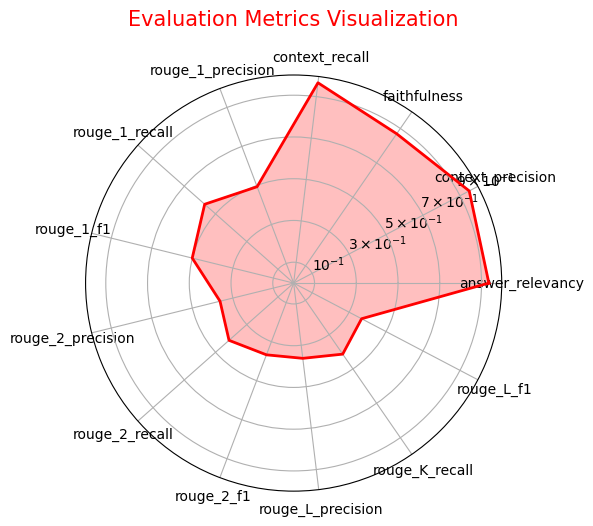

In [196]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='red', alpha=0.25)
ax.plot(angles, values, color='red', linewidth=2)  # Draw the outline of our data

# Labels for each point
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Draw ytick labels to show scale of each dimension
ax.set_rscale('symlog')  # Use a symmetric log scale if your data varies widely
ax.set_rticks([0.1, 0.3, 0.5, 0.7, 0.9])  # You can choose different ticks to better represent your data scale
ax.set_rlabel_position(30)  # Move radial labels away from plotted line

plt.title('Evaluation Metrics Visualization', size=15, color='red', y=1.1)
plt.tight_layout()
plt.show()

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [172]:
heatmap_df = results_viz[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']]

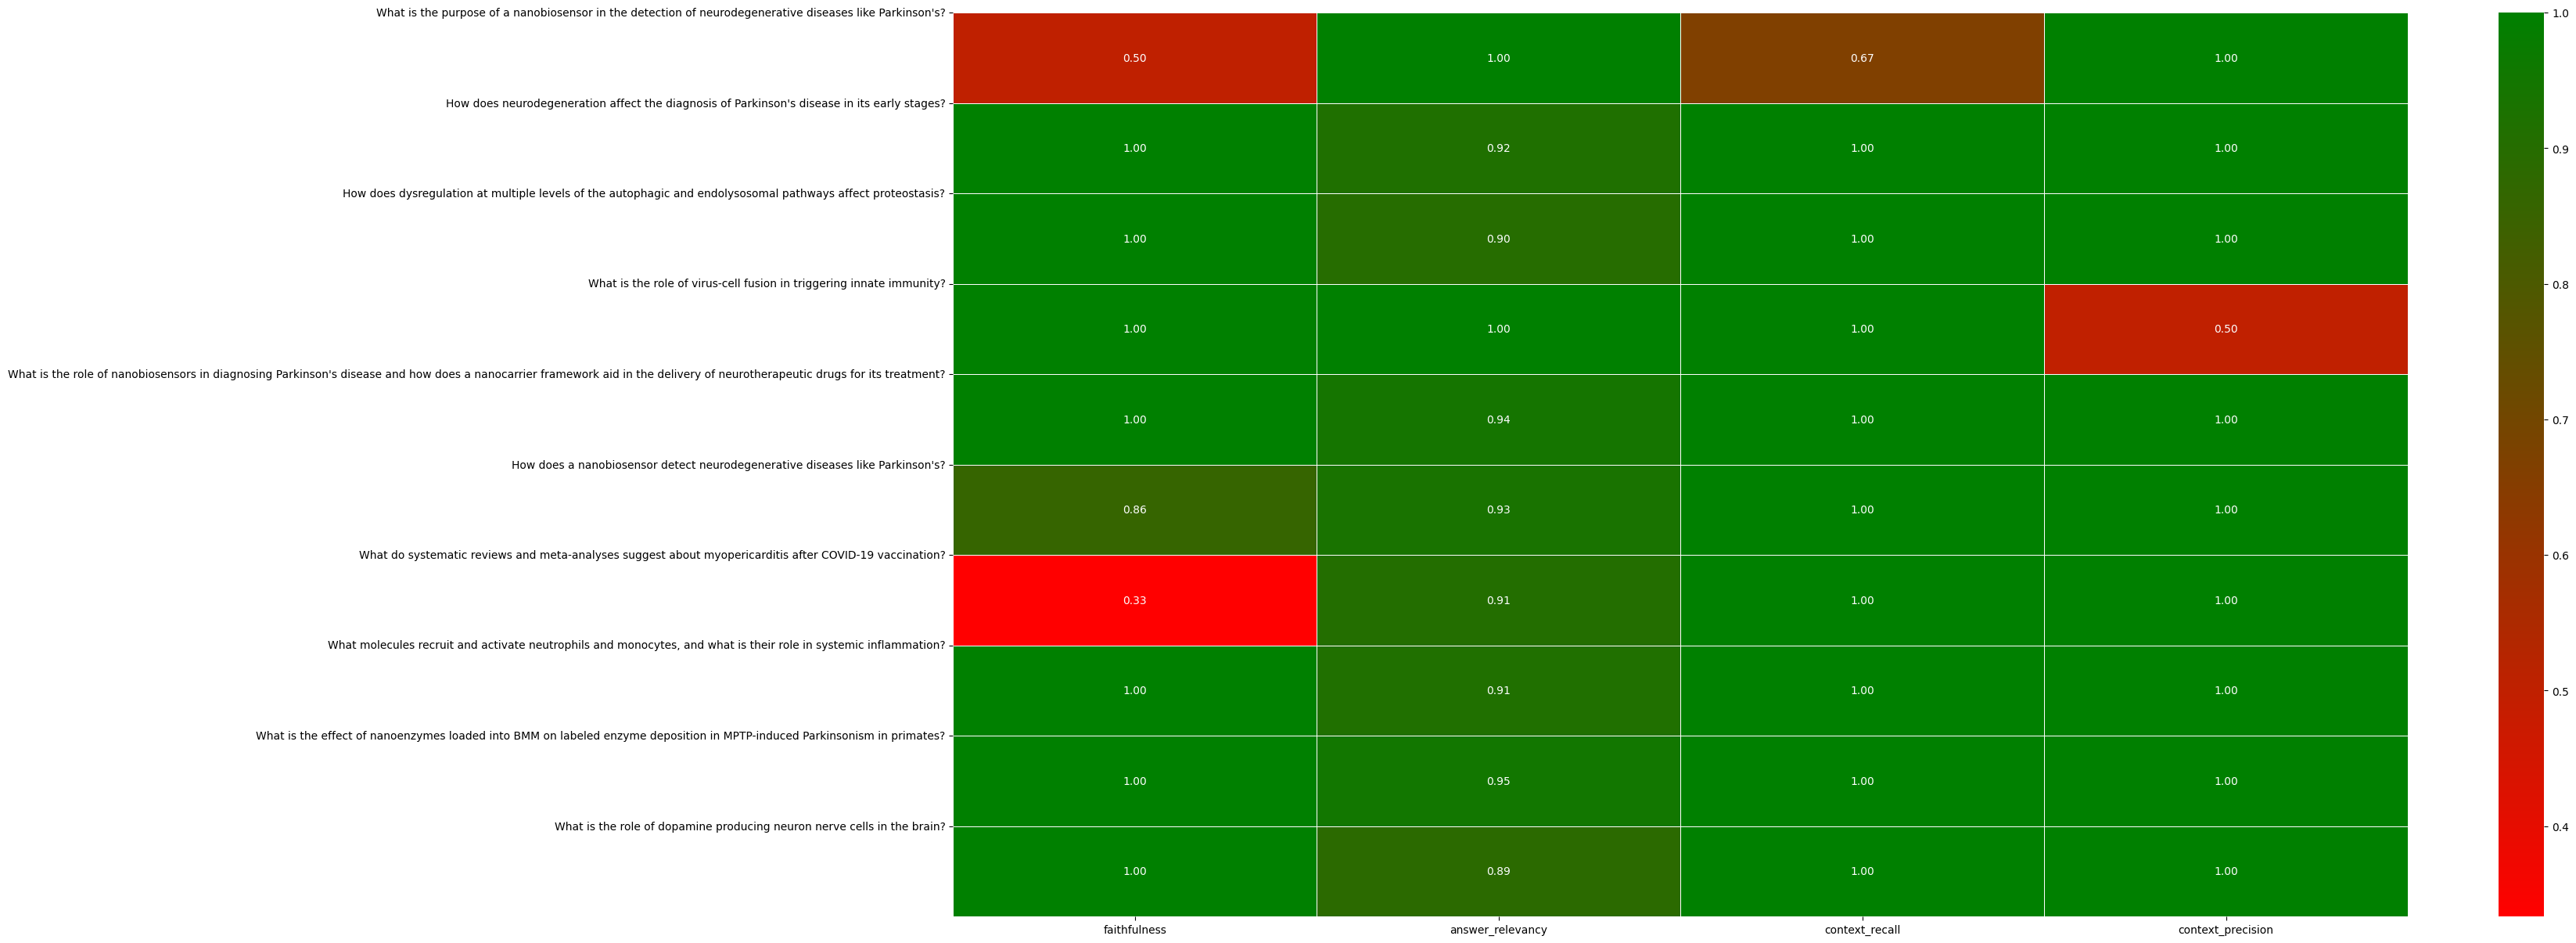

In [175]:
plt.figure(figsize=(30, 15))
cmap = LinearSegmentedColormap.from_list('green_red', ['red',  'green'])
sns.heatmap(heatmap_df, cmap=cmap, annot=True, fmt=".2f", linewidths=0.5)
plt.yticks(ticks = range(len(results_viz["question"])), labels=results_viz["question"], rotation=0)
plt.show()


In [ ]:
results

{'answer_relevancy': 0.9378, 'context_precision': 0.8421, 'faithfulness': 0.8487, 'context_recall': 0.7982}

In [197]:
results_viz.to_excel("/content/drive/My Drive/data/" + 'results_2.xlsx', index=False)  # Change 'filename.xlsx' as needed

In [ ]:
'''Poly(ethyleneimine) (PEI) is a cationic polymer composed of repeating units of ethyleneimine. It has been widely studied as a nonviral vector for gene delivery due to its ability to form complexes with DNA or RNA through electrostatic interactions. These complexes, known as polyplexes, can protect the genetic material from degradation by enzymes and other nucleases in the bloodstream and facilitate its uptake into cells.'''

'Poly(ethyleneimine) (PEI) is a cationic polymer composed of repeating units of ethyleneimine. It has been widely studied as a nonviral vector for gene delivery due to its ability to form complexes with DNA or RNA through electrostatic interactions. These complexes, known as polyplexes, can protect the genetic material from degradation by enzymes and other nucleases in the bloodstream and facilitate its uptake into cells.'

In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [202]:
result_1 = pd.read_excel("/content/drive/My Drive/data/llm_results.xlsx")

In [203]:
result_1

,question,answers,contexts,ground_truth,ground_truth.1,ground_truth.2,faithfulness,context_recall
0,How does immune dysregulation contribute to th...,Immune dysregulation plays a crucial role in t...,"[""CSF and post-mortem brain of Parkinson's dis...",Immune dysregulation contributes to the pathop...,0.988863,1.0,0.625,1.000000
1,How does PD-1 cell death in ovarian cancer-ass...,The authors suggest that PD-1 expression on DC...,"['of antibody or T cell response. However, the...",PD-1 cell death in ovarian cancer-associated D...,0.869130,0.5,0.000,0.000000
2,Why may routine diagnosis not be an attractive...,Routine diagnosis is not an attractive choice ...,['thus it is critical to be aware of this diff...,These techniques are essential for fundamental...,0.994755,0.5,1.000,1.000000
3,What is the purpose of supplementary adjuvants...,The purpose of supplementary adjuvants in mRNA...,['6. Adjuvants and Future Direction\n\nAdjuvan...,The purpose of supplementary adjuvants in mRNA...,1.000000,1.0,1.000,1.000000
4,How can nanotechnology be used for the diagnos...,Nanotechnology can be used to diagnose and tre...,"[""there are currently no drugs that can preven...",Nanotechnology can be used for the diagnosis a...,0.996213,1.0,1.000,1.000000
5,What is the purpose of the detection surface i...,The detection surface in nanobiosensors is whe...,['Nanobiosensor\n\nA biosensor is a device tha...,The purpose of the detection surface in nanobi...,0.974488,1.0,1.000,1.000000
6,How is late stage Parkinson's disease detected?,Late stage Parkinson's disease can be diagnose...,"[""of neurodegen- eration, it is not possible t...",Late stage Parkinson's disease can be detected...,0.939358,0.0,1.000,0.000000
7,How do nanomaterial formulations lower oxidati...,"Nanoenzymes loaded into (1E, 2E)-1,2-bis((6-br...","[""peroxide and may reduce the oxida- tive stre...",Nanomaterial formulations have been shown to l...,0.831331,1.0,1.000,1.000000
8,What are the medicinal properties of Mucuna pr...,Mucuna pruriens is a plant that belongs to the...,"[""Parkinson’s disease treatment can be done wi...",Mucuna pruriens has a variety of medicinal pro...,0.860097,1.0,1.000,1.000000
9,What is the effect of PEI on lysosomal pH acco...,There is no effect of PEI on lysosomal pH acco...,"['40.\n\n41.\n\n42. Benjaminsen, R.V.; Mattebj...",The possible “proton sponge “ effect of polyet...,0.992025,1.0,1.000,1.000000


In [205]:
results_viz.drop(columns=["rouge_scores"], inplace= True)

In [216]:
result_2 = results_viz.rename(columns = {"answer" : "answers"})

In [234]:
result_2['contexts'].apply(type).unique()

array([<class 'numpy.ndarray'>], dtype=object)

In [217]:
result = pd.concat([result_1, result_2], ignore_index=True)

In [220]:
result.drop(columns=["ground_truth.1",	"ground_truth.2",	"faithfulness",	"context_recall",	"answer_relevancy",	"context_precision"], inplace= True)

In [227]:
result

,question,answers,contexts,ground_truth
0,How does immune dysregulation contribute to th...,Immune dysregulation plays a crucial role in t...,"[""CSF and post-mortem brain of Parkinson's dis...",Immune dysregulation contributes to the pathop...
1,How does PD-1 cell death in ovarian cancer-ass...,The authors suggest that PD-1 expression on DC...,"['of antibody or T cell response. However, the...",PD-1 cell death in ovarian cancer-associated D...
2,Why may routine diagnosis not be an attractive...,Routine diagnosis is not an attractive choice ...,['thus it is critical to be aware of this diff...,These techniques are essential for fundamental...
3,What is the purpose of supplementary adjuvants...,The purpose of supplementary adjuvants in mRNA...,['6. Adjuvants and Future Direction\n\nAdjuvan...,The purpose of supplementary adjuvants in mRNA...
4,How can nanotechnology be used for the diagnos...,Nanotechnology can be used to diagnose and tre...,"[""there are currently no drugs that can preven...",Nanotechnology can be used for the diagnosis a...
5,What is the purpose of the detection surface i...,The detection surface in nanobiosensors is whe...,['Nanobiosensor\n\nA biosensor is a device tha...,The purpose of the detection surface in nanobi...
6,How is late stage Parkinson's disease detected?,Late stage Parkinson's disease can be diagnose...,"[""of neurodegen- eration, it is not possible t...",Late stage Parkinson's disease can be detected...
7,How do nanomaterial formulations lower oxidati...,"Nanoenzymes loaded into (1E, 2E)-1,2-bis((6-br...","[""peroxide and may reduce the oxida- tive stre...",Nanomaterial formulations have been shown to l...
8,What are the medicinal properties of Mucuna pr...,Mucuna pruriens is a plant that belongs to the...,"[""Parkinson’s disease treatment can be done wi...",Mucuna pruriens has a variety of medicinal pro...
9,What is the effect of PEI on lysosomal pH acco...,There is no effect of PEI on lysosomal pH acco...,"['40.\n\n41.\n\n42. Benjaminsen, R.V.; Mattebj...",The possible “proton sponge “ effect of polyet...


In [228]:
result.dtypes

question        object
answers         object
contexts        object
ground_truth    object
dtype: object

In [245]:

for i in range(len(result)):

  x = np.array(result['contexts'][i])
  print(x)
  result.at[i, 'contexts'] = x
  print(type(x))
  print()

["CSF and post-mortem brain of Parkinson's disease patients (Tansey et al. 2022). To summarise, the pathophysiology of Parkinson's disease is compositive and caused by a combination of hereditary and environmental factors. Mutations in single or several genes may exacerbate the effects of environmental neuro- toxins (Tran et al. 2020). Mutations related to Parkinson's disease cause mitochondrial and endoplasmic reticulum malfunction, autophagy impairment, and immune dysregu- lation (Abais et al. 2015). Alpha-synuclein aggregation, oxidative stress, ferroptosis, mitochondrial failure, neuro- inflammation, and gut dysbiosis have all been identified as PD mechanisms (Dong-Chen et al. 2023). The"
 "as PD mechanisms (Dong-Chen et al. 2023). The interactions between all these molecular mechanisms complicate the pathogenesis of Parkinson's disease and pose significant challenges to treatment development. However, further research is needed, to understand the specific molecular mechanisms unde

In [257]:
for i in range(len(result)):

  if pd.isna(result['ground_truth'][i]):
        result = result.drop(i)


In [261]:
result.head()

,question,answers,contexts,ground_truth
0,How does immune dysregulation contribute to th...,Immune dysregulation plays a crucial role in t...,"[""CSF and post-mortem brain of Parkinson's dis...",Immune dysregulation contributes to the pathop...
1,How does PD-1 cell death in ovarian cancer-ass...,The authors suggest that PD-1 expression on DC...,"['of antibody or T cell response. However, the...",PD-1 cell death in ovarian cancer-associated D...
2,Why may routine diagnosis not be an attractive...,Routine diagnosis is not an attractive choice ...,['thus it is critical to be aware of this diff...,These techniques are essential for fundamental...
3,What is the purpose of supplementary adjuvants...,The purpose of supplementary adjuvants in mRNA...,['6. Adjuvants and Future Direction\n\nAdjuvan...,The purpose of supplementary adjuvants in mRNA...
4,How can nanotechnology be used for the diagnos...,Nanotechnology can be used to diagnose and tre...,"[""there are currently no drugs that can preven...",Nanotechnology can be used for the diagnosis a...


In [269]:
result_with_index = result.reset_index()

In [271]:
result = result_with_index.drop(columns=["index"])


In [288]:
rresult = result.copy()

In [263]:
# Convert numpy arrays to plain lists
result['contexts'] = result['contexts'].apply(lambda x: x.tolist())

In [312]:
for i in range(len(result)):
  temp = list()
  if len(result['contexts'][i]) != 2:
    temp.append(result['contexts'][i].split("\n")[0][2:])
    temp.append(result['contexts'][i].split("\n")[1][:-2])
    result['contexts'][i] = temp
  else:
    pass






In [313]:
result

,question,answers,contexts,ground_truth
0,How does immune dysregulation contribute to th...,Immune dysregulation plays a crucial role in t...,[CSF and post-mortem brain of Parkinson's dise...,Immune dysregulation contributes to the pathop...
1,How does PD-1 cell death in ovarian cancer-ass...,The authors suggest that PD-1 expression on DC...,"[of antibody or T cell response. However, the ...",PD-1 cell death in ovarian cancer-associated D...
2,Why may routine diagnosis not be an attractive...,Routine diagnosis is not an attractive choice ...,[thus it is critical to be aware of this diffi...,These techniques are essential for fundamental...
3,What is the purpose of supplementary adjuvants...,The purpose of supplementary adjuvants in mRNA...,[6. Adjuvants and Future Direction\n\nAdjuvant...,The purpose of supplementary adjuvants in mRNA...
4,How can nanotechnology be used for the diagnos...,Nanotechnology can be used to diagnose and tre...,[there are currently no drugs that can prevent...,Nanotechnology can be used for the diagnosis a...
5,What is the purpose of the detection surface i...,The detection surface in nanobiosensors is whe...,[Nanobiosensor\n\nA biosensor is a device that...,The purpose of the detection surface in nanobi...
6,How is late stage Parkinson's disease detected?,Late stage Parkinson's disease can be diagnose...,"[of neurodegen- eration, it is not possible to...",Late stage Parkinson's disease can be detected...
7,How do nanomaterial formulations lower oxidati...,"Nanoenzymes loaded into (1E, 2E)-1,2-bis((6-br...",[peroxide and may reduce the oxida- tive stres...,Nanomaterial formulations have been shown to l...
8,What are the medicinal properties of Mucuna pr...,Mucuna pruriens is a plant that belongs to the...,[Parkinson’s disease treatment can be done wit...,Mucuna pruriens has a variety of medicinal pro...
9,What is the effect of PEI on lysosomal pH acco...,There is no effect of PEI on lysosomal pH acco...,"[40.\n\n41.\n\n42. Benjaminsen, R.V.; Mattebje...",The possible “proton sponge “ effect of polyet...


In [316]:
result.dtypes

question        object
answers         object
contexts        object
ground_truth    object
dtype: object

In [326]:
final_dataset = Dataset.from_pandas(result)

In [327]:
final_dataset

Dataset({
    features: ['question', 'answers', 'contexts', 'ground_truth'],
    num_rows: 28
})

In [328]:
final_results = evaluate(dataset)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [329]:
final_results

{'answer_relevancy': 0.9490, 'context_precision': 0.9500, 'faithfulness': 0.8690, 'context_recall': 0.9167}

In [330]:
final_results_viz = final_results.to_pandas()

In [332]:
final_results_viz.head()

,question,answer,contexts,ground_truth,answer_relevancy,context_precision,faithfulness,context_recall
0,What is the purpose of a nanobiosensor in the ...,The purpose of a nanobiosensor in the detectio...,[Table 1 Detection of Parkinson’s disease usin...,A nanobiosensor is a device that combines a tr...,1.000000,1.0,0.5,0.666667
1,How does neurodegeneration affect the diagnosi...,Neurodegeneration affects the diagnosis of Par...,"[of neurodegen- eration, it is not possible to...",Neurodegeneration makes it impossible to diagn...,1.000000,1.0,1.0,1.000000
2,How does dysregulation at multiple levels of t...,Dysregulation at multiple levels of the autoph...,[(CNS) pro- teostasis because of dysregulation...,Dysregulation at multiple levels of the autoph...,0.965323,1.0,1.0,1.000000
3,What is the role of virus-cell fusion in trigg...,The role of virus-cell fusion in triggering in...,"[Cell 2021, 184, 1589–1603. [CrossRef] Chen, N...",The role of virus-cell fusion in triggering in...,1.000000,0.5,1.0,1.000000
4,What is the role of nanobiosensors in diagnosi...,Nanobiosensors play an important role in the d...,[review explores the nanobiosensors as diagnos...,The review explores the role of nanobiosensors...,0.942827,1.0,1.0,1.000000


In [333]:
# Calculate ROUGE scores
final_results_viz['rouge_scores'] = final_results_viz.apply(lambda row: calculate_rouge_scores(row['answer'], row['ground_truth']), axis=1)

In [335]:
rouge_scores = []
for i in range(len(final_results_viz)):
  rouge_scores.append(final_results_viz['rouge_scores'][i])

In [336]:
final_results_viz

,question,answer,contexts,ground_truth,answer_relevancy,context_precision,faithfulness,context_recall,rouge_scores
0,What is the purpose of a nanobiosensor in the ...,The purpose of a nanobiosensor in the detectio...,[Table 1 Detection of Parkinson’s disease usin...,A nanobiosensor is a device that combines a tr...,1.000000,1.0,0.500000,0.666667,"[{'rouge-1': {'r': 0.2619047619047619, 'p': 0...."
1,How does neurodegeneration affect the diagnosi...,Neurodegeneration affects the diagnosis of Par...,"[of neurodegen- eration, it is not possible to...",Neurodegeneration makes it impossible to diagn...,1.000000,1.0,1.000000,1.000000,"[{'rouge-1': {'r': 0.8333333333333334, 'p': 0...."
2,How does dysregulation at multiple levels of t...,Dysregulation at multiple levels of the autoph...,[(CNS) pro- teostasis because of dysregulation...,Dysregulation at multiple levels of the autoph...,0.965323,1.0,1.000000,1.000000,"[{'rouge-1': {'r': 1.0, 'p': 0.5, 'f': 0.66666..."
3,What is the role of virus-cell fusion in trigg...,The role of virus-cell fusion in triggering in...,"[Cell 2021, 184, 1589–1603. [CrossRef] Chen, N...",The role of virus-cell fusion in triggering in...,1.000000,0.5,1.000000,1.000000,"[{'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.99999..."
4,What is the role of nanobiosensors in diagnosi...,Nanobiosensors play an important role in the d...,[review explores the nanobiosensors as diagnos...,The review explores the role of nanobiosensors...,0.942827,1.0,1.000000,1.000000,"[{'rouge-1': {'r': 0.4, 'p': 0.303030303030303..."
5,How does a nanobiosensor detect neurodegenerat...,Nanobiosensors have been shown to be effective...,[spark the attention of researchers in conduct...,A nanobiosensor detects neurodegenerative dise...,0.933103,1.0,0.857143,0.500000,"[{'rouge-1': {'r': 0.36585365853658536, 'p': 0..."
6,What do systematic reviews and meta-analyses s...,Answer: The systematic review and meta-analysi...,"[9 of 11\n\nViruses 2024, 16, 120\n\n33. Dighr...",Systematic reviews and meta-analyses suggest t...,0.906798,1.0,0.333333,1.000000,"[{'rouge-1': {'r': 0.3333333333333333, 'p': 0...."
7,What molecules recruit and activate neutrophil...,Neutrophils are recruited to sites of infectio...,"[by innate immune cells, producing a variety o...","Chemokines such as CCL2, CCL3, CCL4, CCL7, and...",0.914222,1.0,1.000000,1.000000,"[{'rouge-1': {'r': 0.16666666666666666, 'p': 0..."
8,What is the effect of nanoenzymes loaded into ...,Nanoenzymes loaded into BMM increased labelled...,[peroxide and may reduce the oxida- tive stres...,"Nanoenzymes loaded into (1E, 2E)-1,2-bis((6-br...",0.941353,1.0,1.000000,1.000000,"[{'rouge-1': {'r': 0.6666666666666666, 'p': 0...."
9,What is the role of dopamine producing neuron ...,"Dopamine is a neurotransmitter in the brain, a...",[Dopamine producing Neuron nerve cells \ - ‘Sy...,Dopamine producing neuron nerve cells in the b...,0.886266,1.0,1.000000,1.000000,"[{'rouge-1': {'r': 0.6666666666666666, 'p': 0...."


In [354]:
# rouge_1_sum = {'r': 0, 'p': 0, 'f': 0}
# rouge_2_sum = {'r': 0, 'p': 0, 'f': 0}
# rouge_l_sum = {'r': 0, 'p': 0, 'f': 0}
# avg_rouge_1_precision = 0
# avg_rouge_1_recall = 0
# avg_rouge_1_f = 0
# avg_rouge_2_precision = 0
# avg_rouge_2_recall = 0
# avg_rouge_2_f = 0
# avg_rouge_L_precision = 0
# avg_rouge_L_recall = 0
# avg_rouge_L_f = 0
# k = 8

# n = len(rouge_scores)
# rougue_1_r = []
# rougue_1_p = []
# rougue_1_f = []
# rougue_2_r = []
# rougue_2_p = []
# rougue_2_f = []
# rougue_L_r = []
# rougue_L_p = []
# rougue_L_f = []
# # Sum up all the scores
# for score in rouge_scores:
#     rougue_1_r.append(score[0]['rouge-1']['r'])
#     rougue_1_p.append(score[0]['rouge-1']['p'])
#     rougue_1_f.append(score[0]['rouge-1']['f'])
#     rougue_2_r.append(score[0]['rouge-2']['r'])
#     rougue_2_p.append(score[0]['rouge-2']['p'])
#     rougue_2_f.append(score[0]['rouge-2']['f'])
#     rougue_L_r.append(score[0]['rouge-l']['r'])
#     rougue_L_p.append(score[0]['rouge-l']['p'])
#     rougue_L_f.append(score[0]['rouge-l']['f'])




In [337]:
rouge_1_sum = {'r': 0, 'p': 0, 'f': 0}
rouge_2_sum = {'r': 0, 'p': 0, 'f': 0}
rouge_l_sum = {'r': 0, 'p': 0, 'f': 0}
avg_rouge_1_precision = 0
avg_rouge_1_recall = 0
avg_rouge_1_f = 0
avg_rouge_2_precision = 0
avg_rouge_2_recall = 0
avg_rouge_2_f = 0
avg_rouge_L_precision = 0
avg_rouge_L_recall = 0
avg_rouge_L_f = 0

n = len(rouge_scores)

# Sum up all the scores
for score in rouge_scores:
    rouge_1_sum['r'] += score[0]['rouge-1']['r']
    rouge_1_sum['p'] += score[0]['rouge-1']['p']
    rouge_1_sum['f'] += score[0]['rouge-1']['f']
    rouge_2_sum['r'] += score[0]['rouge-2']['r']
    rouge_2_sum['p'] += score[0]['rouge-2']['p']
    rouge_2_sum['f'] += score[0]['rouge-2']['f']
    rouge_l_sum['r'] += score[0]['rouge-l']['r']
    rouge_l_sum['p'] += score[0]['rouge-l']['p']
    rouge_l_sum['f'] += score[0]['rouge-l']['f']

# Calculate averages
avg_rouge_1 = {k: v / n for k, v in rouge_1_sum.items()}
avg_rouge_2 = {k: v / n for k, v in rouge_2_sum.items()}
avg_rouge_l = {k: v / n for k, v in rouge_l_sum.items()}

# Print averages
avg_rouge_1_precision = avg_rouge_1['p']
avg_rouge_1_recall = avg_rouge_1['r']
avg_rouge_1_f = avg_rouge_1['f']
avg_rouge_2_precision = avg_rouge_2['p']
avg_rouge_2_recall = avg_rouge_2['r']
avg_rouge_2_f = avg_rouge_2['f']
avg_rouge_L_precision = avg_rouge_l['p']
avg_rouge_L_recall = avg_rouge_l['r']
avg_rouge_L_f = avg_rouge_l['f']

In [338]:
Final_Results = final_results

In [355]:
Final_Results["rouge_1_precision"] = avg_rouge_1_precision
Final_Results["rouge_1_recall"] = avg_rouge_1_recall
Final_Results["rouge_1_f1"] = avg_rouge_1_f
Final_Results["rouge_2_precision"] = avg_rouge_2_precision
Final_Results["rouge_2_recall"] = avg_rouge_2_recall
Final_Results["rouge_2_f1"] = avg_rouge_2_f
Final_Results["rouge_L_precision"] = avg_rouge_2_precision
Final_Results["rouge_L_recall"] = avg_rouge_2_recall
Final_Results["rouge_L_f1"] = avg_rouge_2_f
Final_Results

{'answer_relevancy': 0.9490, 'context_precision': 0.9500, 'faithfulness': 0.8690, 'context_recall': 0.9167, 'rouge_1_precision': 0.9231, 'rouge_1_recall': 0.6667, 'rouge_1_f1': 0.7742, 'rouge_2_precision': 0.8333, 'rouge_2_recall': 0.5882, 'rouge_2_f1': 0.6897, 'rouge_L_precision': 0.8333, 'rouge_K_recall': 0.5882, 'rouge_L_f1': 0.6897}

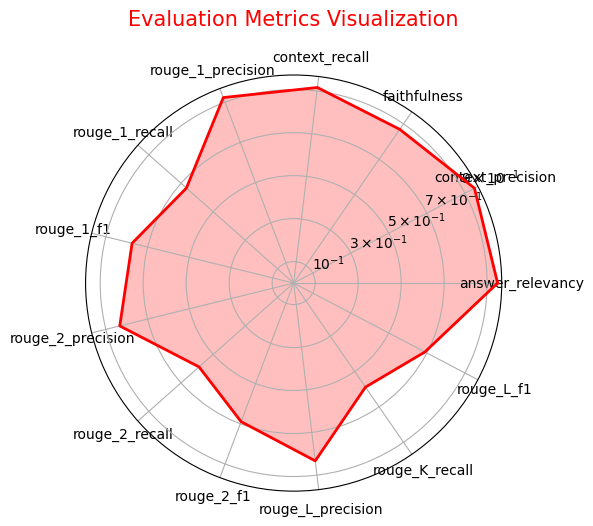

In [356]:
import numpy as np

labels = list(Final_Results.keys())
values = list(Final_Results.values())

# Number of variables we're plotting.
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made in a circular (not polygon) space, so we need to "complete the loop"
values += values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='red', alpha=0.25)
ax.plot(angles, values, color='red', linewidth=2)  # Draw the outline of our data

# Labels for each point
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Draw ytick labels to show scale of each dimension
ax.set_rscale('symlog')  # Use a symmetric log scale if your data varies widely
ax.set_rticks([0.1, 0.3, 0.5, 0.7, 0.9])  # You can choose different ticks to better represent your data scale
ax.set_rlabel_position(30)  # Move radial labels away from plotted line

plt.title('Evaluation Metrics Visualization', size=15, color='red', y=1.1)
plt.tight_layout()
plt.show()

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

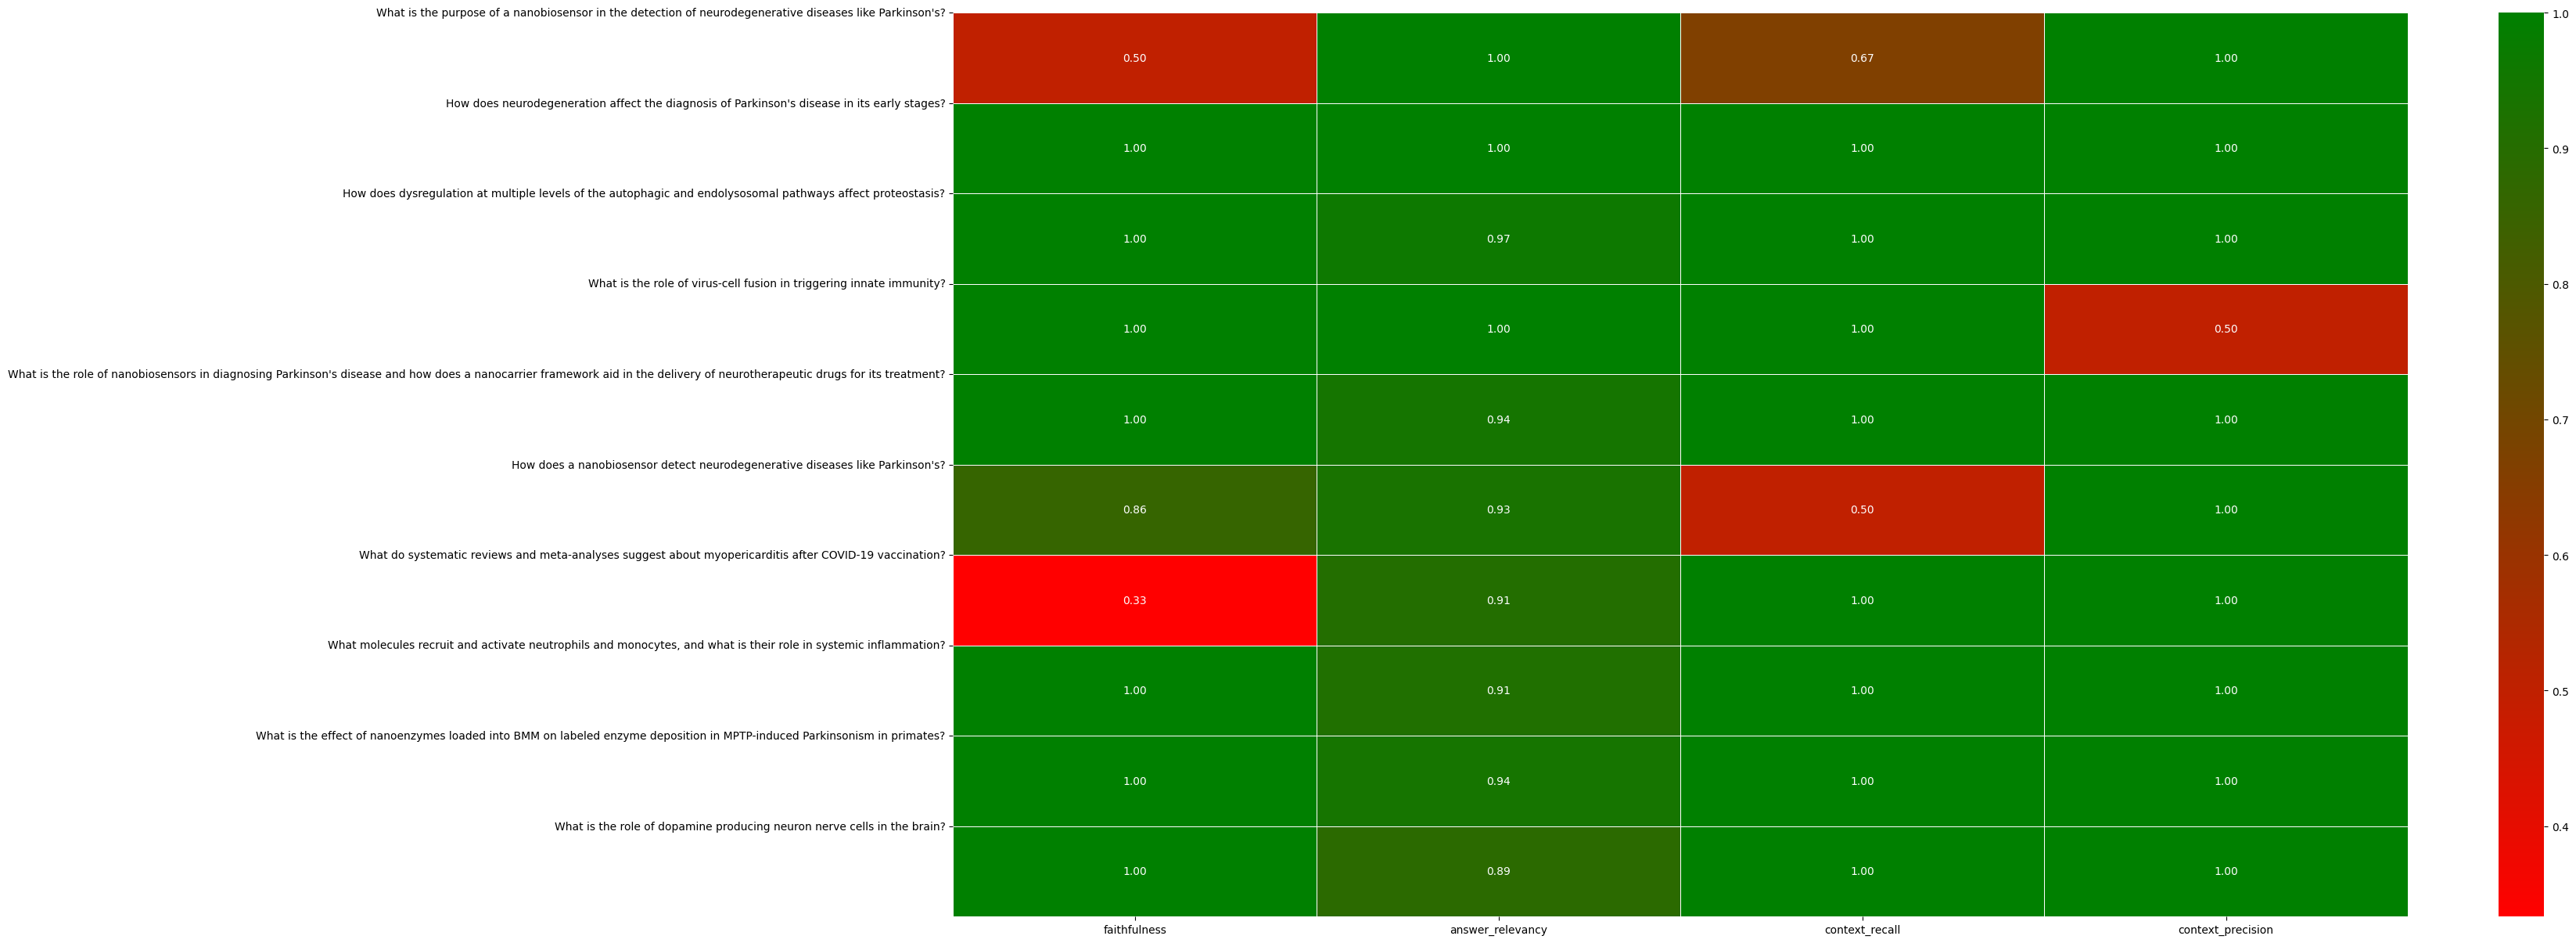

In [342]:
heatmap_df = final_results_viz[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']]

plt.figure(figsize=(30, 15))
cmap = LinearSegmentedColormap.from_list('green_red', ['red',  'green'])
sns.heatmap(heatmap_df, cmap=cmap, annot=True, fmt=".2f", linewidths=0.5)
plt.yticks(ticks = range(len(final_results_viz["question"])), labels=final_results_viz["question"], rotation=0)
plt.show()
